In [2]:
"""Vamos a trabajar en tres modelos predictivos para cancelaciones de reservas hoteleras: arbol de decisión, random forest y xgboost"""

'Vamos a trabajar en tres modelos predictivos para cancelaciones de reservas hoteleras: arbol de decisión, random forest y xgboost'

Importanción de librerias clave para trabajar con los modelos predictivos seleccionados


In [3]:
#importamos las librerias necesarias para poder trabajar los modelos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)


In [4]:
#ahora anexamos base de datos con la que vamos a trabajar
train = pd.read_csv('competencia_icd_train.csv')
test = pd.read_csv('competencia_icd_test.csv')

In [8]:
#Procedemos a empezar con el EDA
train.info() #para verificar nulos o nan
"""No hay nulos ni nan por lo que la base de datos esta limpia"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95118 entries, 0 to 95117
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hotel                      95118 non-null  object 
 1   arrival_date_month         95118 non-null  object 
 2   arrival_date_year          95118 non-null  int64  
 3   arrival_date_week_number   95118 non-null  int64  
 4   arrival_date_day_of_month  95118 non-null  int64  
 5   stays_in_weekend_nights    95118 non-null  int64  
 6   stays_in_week_nights       95118 non-null  int64  
 7   adults                     95118 non-null  int64  
 8   children                   95118 non-null  float64
 9   babies                     95118 non-null  int64  
 10  country                    95118 non-null  object 
 11  market_segment             95118 non-null  object 
 12  distribution_channel       95118 non-null  object 
 13  previous_cancellations     95118 non-null  int

In [21]:
train.head(3)

,hotel,arrival_date_month,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,market_segment,distribution_channel,previous_cancellations,lead_time,booking_changes,deposit_type,customer_type,is_canceled
0,City Hotel,April,2016,15,4,1,4,2,0.0,0,FIN,Online TA,TA/TO,0,67,0,No Deposit,Transient,1
1,City Hotel,July,2016,28,7,1,3,2,0.0,0,USA,Direct,Direct,0,24,0,No Deposit,Transient,1
2,Resort Hotel,November,2016,49,29,0,2,2,0.0,0,SWE,Corporate,Corporate,0,76,0,No Deposit,Transient-Party,0


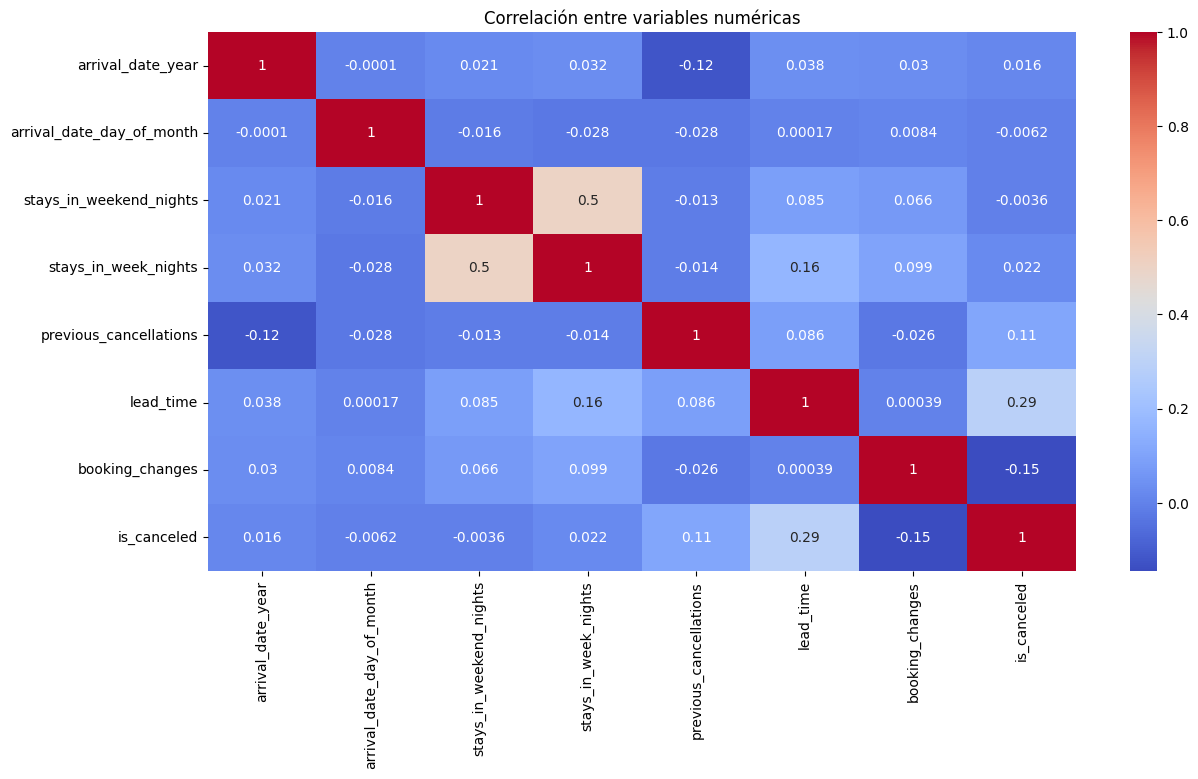

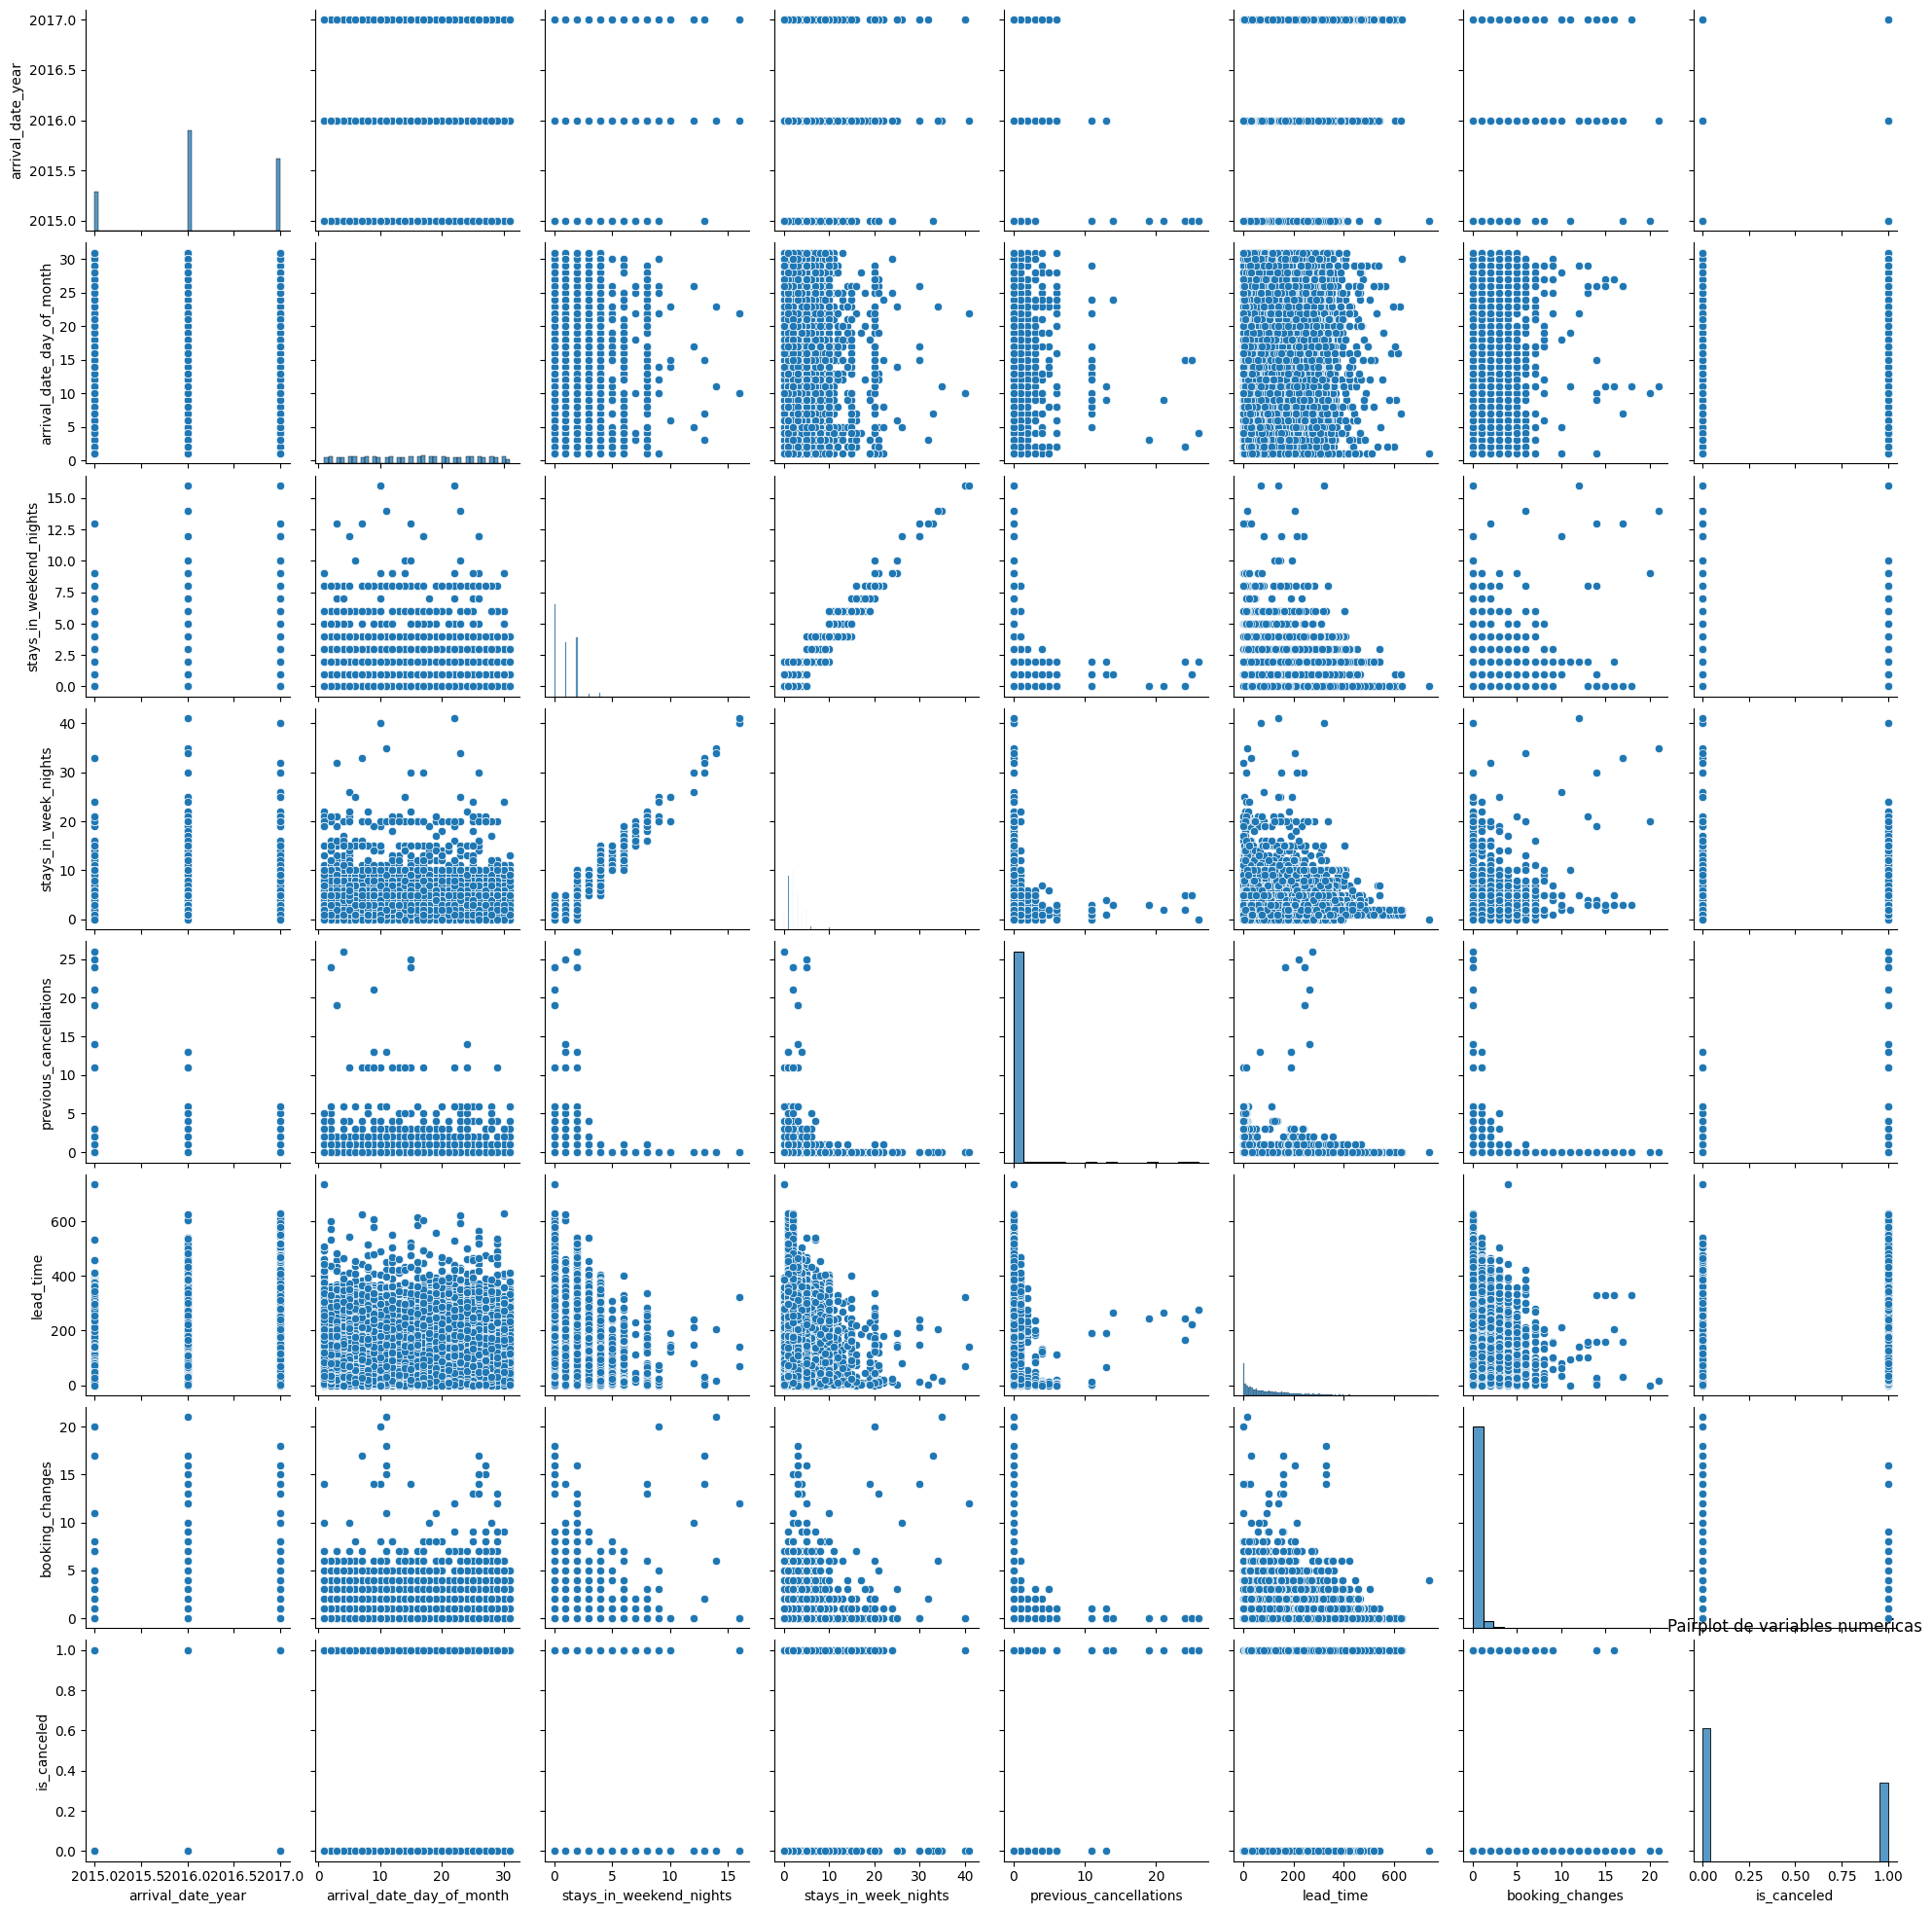

In [139]:
#Vamos a hacer eda con las principales variables numericas, ya que las tipo objeto o str las vamos a encodear posteriormente
train.num = train[['arrival_date_year','arrival_date_day_of_month','stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations',\
             'lead_time', 'booking_changes', 'is_canceled']]

corr = train.num.corr()
plt.figure(figsize=(14, 7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap ="coolwarm")
plt.title("Correlación entre variables numéricas")
plt.show()

#Vamos a trabajar con pairplot
sns.pairplot(train.num)
plt.title("Pairplot de variables numericas")
plt.show()

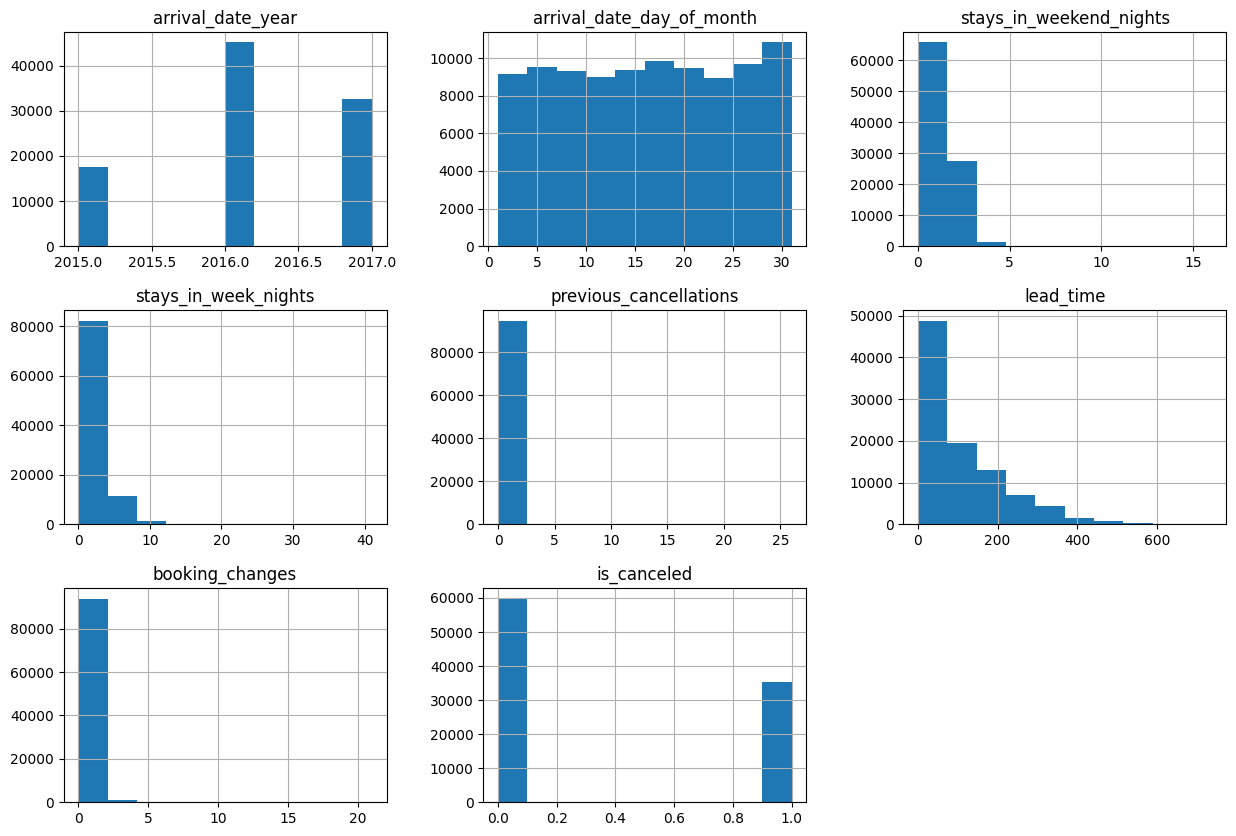

'El histograma es un grafico escencial que nos ayuda a tener perspectiva de la distribución de los datos que manejamosen este caso podemos ver que algunas son variables discretas mientras que otras continuas, es ideal siempre trabajar con este'

In [138]:
#Ahora vamos a vamos a ver el histograma
train.num.hist(figsize=(15, 10))
plt.show()
"""El histograma es un grafico escencial que nos ayuda a tener perspectiva de la distribución de los datos que manejamos\
en este caso podemos ver que algunas son variables discretas mientras que otras continuas, es ideal siempre trabajar con este"""

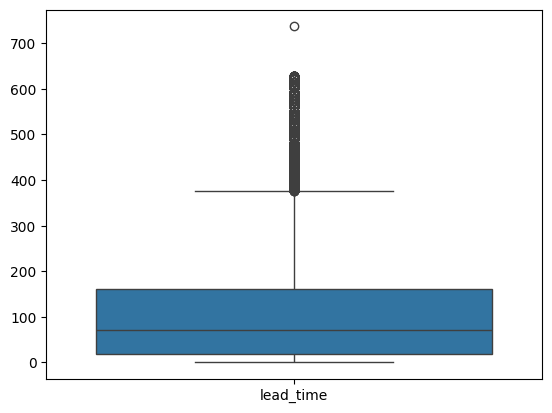

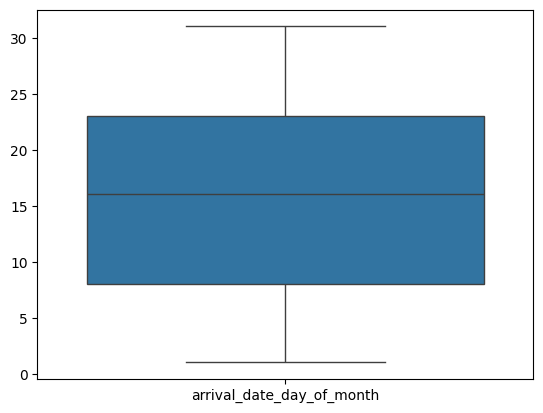

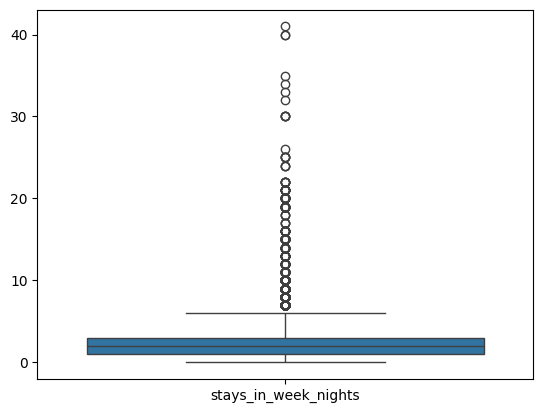

In [146]:
"""Trabajamos con boxplots para poder encontrar outliers"""
sns.boxplot(train.num[["lead_time"]])
plt.show()
sns.boxplot(train.num[["arrival_date_day_of_month"]])
plt.show()
sns.boxplot(train.num[["stays_in_week_nights"]])
plt.show()

In [28]:
train.info()
#Cambiamos el tipo de dato "children en float a int"
train['children'] = train['children'].astype(int)
test['children'] = test['children'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95118 entries, 0 to 95117
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   hotel                      95118 non-null  object
 1   arrival_date_year          95118 non-null  int64 
 2   arrival_date_day_of_month  95118 non-null  int64 
 3   stays_in_weekend_nights    95118 non-null  int64 
 4   stays_in_week_nights       95118 non-null  int64 
 5   adults                     95118 non-null  int64 
 6   children                   95118 non-null  int64 
 7   babies                     95118 non-null  int64 
 8   country                    95118 non-null  object
 9   market_segment             95118 non-null  object
 10  distribution_channel       95118 non-null  object
 11  previous_cancellations     95118 non-null  int64 
 12  lead_time                  95118 non-null  int64 
 13  booking_changes            95118 non-null  int64 
 14  deposi

Finalizado el EDA- vamos a tomar decisiones como la creación de pipeline para poner en marcha los modelos de trabajo:
DecisionTree,
RandomForest,
XGBoost

In [37]:
#Dado que hay muchas de estas variables que son relevantes pero sin embargo hacer el analisis de exploración implicaria convertirlo vamos a trabajar con
#pipeline, onehotencoder y standarscaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


In [108]:
#importamos train test split para poder dividir las areas a entrenar en un arbol basico
from sklearn.model_selection import train_test_split
#Dividimos el data frame
X = train.drop("is_canceled", axis= 1)
y = train["is_canceled"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entrenamos el modelo basico de arbol
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#aplicamos el pipeline con onehotencoder y standarscaler
categoricas = ['hotel', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
numericas = ['arrival_date_year','arrival_date_day_of_month','stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations',\
             'lead_time', 'booking_changes']

#Creamos transformador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', StandardScaler(), numericas)
    ])
#Construimos Pipeline con preprocesamiento y modelo tree
tree= Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

#Entrenamos el modelo
tree.fit(X_train, y_train)

print("Pipeline TreeClassifier entrenado con éxito ")


Pipeline TreeClassifier entrenado con éxito 


In [125]:
# Hacemos predicciones en el conjunto de entrenamiento usando el pipeline
y_test_pred = tree.predict(X_test)

# Calculamos el accuracy comparando las predicciones con las etiquetas verdaderas
tree_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", tree_accuracy)
print(classification_report(y_test, y_test_pred))

Accuracy: 0.8114486963835156
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     11964
           1       0.75      0.75      0.75      7060

    accuracy                           0.81     19024
   macro avg       0.80      0.80      0.80     19024
weighted avg       0.81      0.81      0.81     19024



In [89]:
from sklearn.ensemble import RandomForestClassifier #ahora provamos con randomforest
from sklearn.model_selection import RandomizedSearchCV #quiero utilizar randomizedsearchcv

param_dist = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False]
}

#Construimos Pipeline con preprocesamiento y modelo tree
randomf= Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])
#aplico RandomizedSearchCV para encontrar los mejores parametros
# Aplicar RandomizedSearchCV para encontrar los mejores parámetros
random_search = RandomizedSearchCV(
    estimator=randomf,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones aleatorias
    cv=3,  # Validación cruzada
    scoring="f1",  # Optimizar basado en F1-score
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Entrenar el modelo con búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar mejores parámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor F1-score obtenido:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]



Mejores hiperparámetros: {'classifier__n_estimators': np.int64(200), 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20, 'classifier__bootstrap': True}
Mejor F1-score obtenido: nan


In [103]:
# Crear modelo optimizado con los mejores parámetros


preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
    ('num', StandardScaler(), numericas)
])

best_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=1,
        max_depth=20,
        bootstrap=True
    ))
])

# Entrenar el modelo
best_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'country',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('num', StandardScaler(),
                                                  ['arrival_date_year',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'previous_cancellations',
                                                   'lead_time',
                                                   'booking_changes'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=10,
                                        n_estimators=200))])

In [105]:
# Evaluar el modelo con datos nuevos (X_test)
rf_pred = best_rf.predict(X_test)

# Imprimir métricas de desempeño
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_pred))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87     11964
           1       0.91      0.58      0.71      7060

    accuracy                           0.82     19024
   macro avg       0.85      0.77      0.79     19024
weighted avg       0.84      0.82      0.81     19024



In [114]:
#importamos XGBoost
from xgboost import XGBClassifier


param_dist = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__gamma": [0, 0.1, 0.3, 0.5]
}
# Crear el pipeline con preprocesamiento y modelo base
XGB_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Configurar RandomizedSearchCV
random_search_XGB = RandomizedSearchCV(
    estimator=XGB_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo con búsqueda aleatoria
random_search_XGB.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", random_search_XGB.best_params_)
print("Mejor F1-score obtenido:", random_search_XGB.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[21:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Mejores hiperparámetros: {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.6}
Mejor F1-score obtenido: 0.7492340324714467


In [117]:
# Crear modelo optimizado con los mejores parámetros


preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
    ('num', StandardScaler(), numericas)
])

xgb_rm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        classifier__learning_rate=0.1,
        classifier__subsample=0.8,
        classifier__colsample_bytree=0.6,
        classifier__gamma=0.5,

        max_depth=7,
        bootstrap=True
    ))
])

# Entrenar el modelo
xgb_rm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[21:39:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bootstrap", "classifier__colsample_bytree", "classifier__gamma", "classifier__learning_rate", "classifier__subsample" } are not used.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'country',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('num', StandardScaler(),
                                                  ['arrival_date_year',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'previous_cancellations',
                                                   '...
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, ...))])

In [118]:
rgb_pred = xgb_rm.predict(X_test)
print(classification_report(y_test, rgb_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     11964
           1       0.82      0.71      0.76      7060

    accuracy                           0.83     19024
   macro avg       0.83      0.81      0.82     19024
weighted avg       0.83      0.83      0.83     19024



In [120]:
#vamos a ver la matriz de confusión para cada modelo
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#creamos la matriz de confusión para cada modelo
cm_tree = confusion_matrix(y_test, y_test_pred)
cm_random = confusion_matrix(y_test, rf_pred)
cm_XGB = confusion_matrix(y_test, rgb_pred)


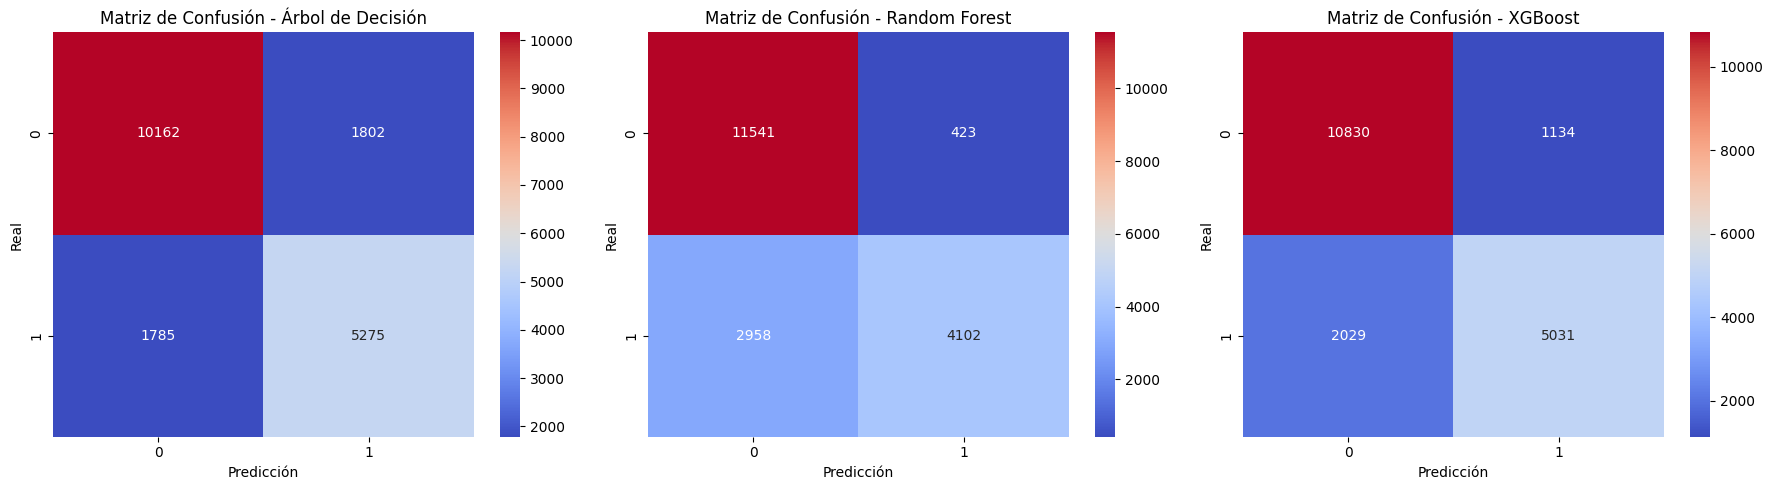

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una figura con tres subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Lista de matrices y títulos
matrices = [cm_tree, cm_random, cm_XGB]
titulos = ["Árbol de Decisión", "Random Forest", "XGBoost"]

# Iterar sobre cada matriz y graficarla
for i, (cm, titulo) in enumerate(zip(matrices, titulos)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=axes[i])
    axes[i].set_title(f"Matriz de Confusión - {titulo}")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

# Ajustar diseño y mostrar la figura
plt.tight_layout()
plt.show()

In [124]:
from sklearn.metrics import classification_report

# Obtener los reportes de cada modelo
report_tree = classification_report(y_test, y_test_pred, output_dict=True)
report_random = classification_report(y_test, rf_pred, output_dict=True)
report_XGB = classification_report(y_test, rgb_pred, output_dict=True)

# Mostrar recall y F1-score para cada modelo
print("Árbol de Decisión:")
print("Recall:", report_tree["weighted avg"]["recall"])
print("F1-Score:", report_tree["weighted avg"]["f1-score"])

print("\nRandom Forest:")
print("Recall:", report_random["weighted avg"]["recall"])
print("F1-Score:", report_random["weighted avg"]["f1-score"])

print("\nXGBoost:")
print("Recall:", report_XGB["weighted avg"]["recall"])
print("F1-Score:", report_XGB["weighted avg"]["f1-score"])

Árbol de Decisión:
Recall: 0.8114486963835156
F1-Score: 0.8114950374263135

Random Forest:
Recall: 0.8222771236333053
F1-Score: 0.811345095493023

XGBoost:
Recall: 0.8337363330529857
F1-Score: 0.8311077388201384


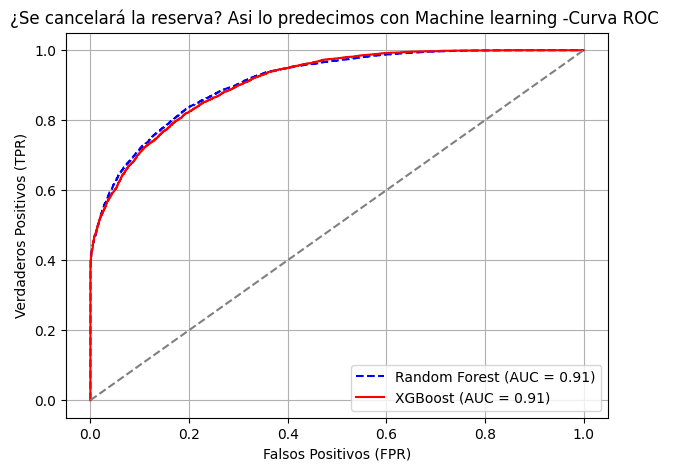

In [155]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de cada modelo
y_probs_tree = best_rf.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva
y_probs_XGB = random_search_XGB.best_estimator_.predict_proba(X_test)[:, 1]

# Calcular curvas ROC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_probs_tree)
fpr_XGB, tpr_XGB, _ = roc_curve(y_test, y_probs_XGB)

# Calcular AUC
auc_tree = auc(fpr_tree, tpr_tree)
auc_XGB = auc(fpr_XGB, tpr_XGB)

# Graficamos las curvas
plt.figure(figsize=(7,5))
plt.plot(fpr_tree, tpr_tree, label=f'Random Forest (AUC = {auc_tree:.2f})', linestyle='--', color='blue')
plt.plot(fpr_XGB, tpr_XGB, label=f'XGBoost (AUC = {auc_XGB:.2f})', linestyle='-', color='red')

# Línea base (clasificación aleatoria)
plt.plot([0,1], [0,1], linestyle='dashed', color='gray')

plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdaderos Positivos (TPR)")
plt.title("¿Se cancelará la reserva? Asi lo predecimos con Machine learning -Curva ROC " )
plt.legend()
plt.grid()

plt.show()